In [75]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import display, clear_output
import time

class GridWorldEnv(gym.Env):
    def __init__(self, n=5, start_pos=(0, 0), goal_pos=None, block_percentage=5):
        super(GridWorldEnv, self).__init__()
        
        self.n = n
        self.grid_size = (n, n)
        
        # Define the action space: 0 = left, 1 = right, 2 = up, 3 = down
        self.action_space = spaces.Discrete(4)
        
        # Define the observation space, which is the position of the agent on the grid
        self.observation_space = spaces.Tuple((
            spaces.Discrete(n),
            spaces.Discrete(n)
        ))
        
        # Set the starting position of the agent
        self.start_pos = start_pos
        self.current_pos = self.start_pos
        
        # Set the goal position
        self.goal_pos = goal_pos if goal_pos else (n-1, n-1)
        
        # Set the blocked cells, generate random blocked cells
        num_cells = n * n
        num_blocked = int((block_percentage / 100) * num_cells)
        
        self.blocked_cells = []
        while len(self.blocked_cells) < num_blocked:
            cell = (random.randint(0, n-1), random.randint(0, n-1))
            if cell != self.start_pos and cell != self.goal_pos and cell not in self.blocked_cells:
                self.blocked_cells.append(cell)
        
        # Create grid with obstacles
        self.grid = np.zeros(self.grid_size)
        for cell in self.blocked_cells:
            self.grid[cell] = -1  # Mark blocked cells as -1
        
    def reset(self):
        # Reset agent's position to start
        self.current_pos = self.start_pos
        return self.current_pos

    def step(self, action):
        x, y = self.current_pos

        # Take action based on the agent's current position
        if action == 0:  # Left
            y = max(0, y - 1)
        elif action == 1:  # Right
            y = min(self.n - 1, y + 1)
        elif action == 2:  # Up
            x = max(0, x - 1)
        elif action == 3:  # Down
            x = min(self.n - 1, x + 1)
        
        next_pos = (x, y)

        # Check if the next position is blocked
        if next_pos in self.blocked_cells:
            next_pos = self.current_pos  # Stay in the same position if blocked

        # Set the new current position
        self.current_pos = next_pos

        # Check if the agent reached the goal
        if self.current_pos == self.goal_pos:
            reward = 10  # Reward for reaching the goal
            done = True
        else:
            reward = -1  # Small penalty for each step taken
            done = False

        return self.current_pos, reward, done, {}

    def render(self, mode='human'):
        grid = np.copy(self.grid)

        # Mark the agent's position
        grid[self.current_pos] = 1

        # Mark the goal position
        grid[self.goal_pos] = 2

        # Display the grid as an image
        cmap = colors.ListedColormap(['white', 'blue', 'red', 'black'])
        bounds = [-1, 0, 1, 2, 3]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots()
        ax.imshow(grid, cmap=cmap, norm=norm)

        # Remove default grid lines and ticks
        ax.set_xticks(np.arange(self.n) + 0.5, minor=True)
        ax.set_yticks(np.arange(self.n) + 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=2)  # Square boundaries

        ax.set_xticks([])  # Remove tick marks
        ax.set_yticks([])  # Remove tick marks

        # Render agent, goal, and blocked cells in the center of the squares
        for i in range(self.n):
            for j in range(self.n):
                if (i, j) == self.current_pos:
                    ax.text(j, i, 'A', ha='center', va='center', fontsize=12, color='blue')
                elif (i, j) == self.goal_pos:
                    ax.text(j, i, 'G', ha='center', va='center', fontsize=12, color='red')
                elif (i, j) in self.blocked_cells:
                    ax.text(j, i, 'X', ha='center', va='center', fontsize=12, color='black')

        plt.title(f"Agent at {self.current_pos}, Goal at {self.goal_pos}")
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(0.3)
        plt.close()

    def show_final(self):
        fig, ax = plt.subplots()
        ax.imshow(self.grid, cmap=colors.ListedColormap(['white', 'blue', 'red', 'black']),
                  norm=colors.BoundaryNorm([-1, 0, 1, 2, 3], 4))

        # Remove default grid lines and ticks
        ax.set_xticks(np.arange(self.n) + 0.5, minor=True)
        ax.set_yticks(np.arange(self.n) + 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=2)  # Square boundaries

        ax.set_xticks([])  # Remove tick marks
        ax.set_yticks([])  # Remove tick marks

        # Render agent, start, goal, and blocked cells in the center of the squares
        for i in range(self.n):
            for j in range(self.n):
                if (i, j) == self.current_pos:
                    ax.text(j, i, 'A', ha='center', va='center', fontsize=12, color='blue')
                elif (i, j) == self.start_pos:
                    ax.text(j, i, 'S', ha='center', va='center', fontsize=12, color='green')  # Starting point
                elif (i, j) == self.goal_pos:
                    ax.text(j, i, 'G', ha='center', va='center', fontsize=12, color='red')  # Goal point
                elif (i, j) in self.blocked_cells:
                    ax.text(j, i, 'X', ha='center', va='center', fontsize=12, color='black')

        plt.title(f"Agent at {self.current_pos}, Goal at {self.goal_pos}")
        plt.show()

# Define policy
def run_policy(env, q_table):
    state = env.reset()
    done = False
    env.render()
    while not done:
        action = np.argmax(q_table[state[0], state[1]])
        state, _, done, _ = env.step(action)
        env.render()
    env.show_final()

# Define grid size and blocked cells percentage
n = 8
start_pos = (0, 0)
goal_pos = (n-1, n-1)
block_percentage = 20

env = GridWorldEnv(n=n, start_pos=start_pos, goal_pos=goal_pos, block_percentage=block_percentage)

# Q-learning parameters
q_table = np.zeros((n, n, env.action_space.n))
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 1000
max_steps = 100

# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state[0], state[1]])  # Exploit learned values
        
        next_state, reward, done, _ = env.step(action)
        
        # Update Q-value
        q_table[state[0], state[1], action] = q_table[state[0], state[1], action] + alpha * (
            reward + gamma * np.max(q_table[next_state[0], next_state[1]]) - q_table[state[0], state[1], action]
        )
        
        state = next_state
        total_reward += reward
        
        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)

    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")

print("Training finished!")


Episode 100, Total Reward: -100, Epsilon: 0.6057704364907278
Episode 200, Total Reward: -10, Epsilon: 0.3669578217261671
Episode 300, Total Reward: -11, Epsilon: 0.22229219984074702
Episode 400, Total Reward: -3, Epsilon: 0.1346580429260134
Episode 500, Total Reward: -5, Epsilon: 0.1
Episode 600, Total Reward: -3, Epsilon: 0.1
Episode 700, Total Reward: -9, Epsilon: 0.1
Episode 800, Total Reward: -4, Epsilon: 0.1
Episode 900, Total Reward: -3, Epsilon: 0.1
Episode 1000, Total Reward: -3, Epsilon: 0.1
Training finished!


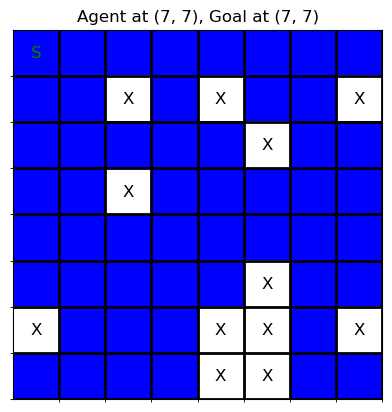

In [76]:
# Test the trained agent
run_policy(env, q_table)